In [1]:
# import pandas as pd
# import numpy as np
# import csv
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# import opencc
# from gensim.models import KeyedVectors, Word2Vec
# from numpy.linalg import norm
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns

# Data Preprocessing

In [2]:
import pandas as pd
import opencc

In [3]:
# Load the datasets
df_male = pd.read_csv("data/1976_raw_male.csv")
df_female = pd.read_csv("data/1976_raw_female.csv")
df_neutral = pd.read_csv("data/1976_raw_neutral.csv")

In [4]:
# Length
print(f"Male: {len(df_male)}")
print(f"Female: {len(df_female)}")
print(f"Neutral: {len(df_neutral)}")

Male: 789
Female: 1113
Neutral: 666


In [5]:
# Add gender column
df_male['gender'] = 'male'
df_female['gender'] = 'female'
df_neutral['gender'] = 'neutral'

In [6]:
# Merge
df = pd.concat([df_male, df_female, df_neutral], ignore_index=True)

In [7]:
# Translate
converter = opencc.OpenCC('t2s.json')
for col in df.columns:
    if col == 'detail_url':
        continue
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: converter.convert(x) if isinstance(x, str) else x)

In [8]:
# Clean description
if 'description' in df.columns:
    df['description'] = df['description'].replace({r'\r\n|\n|\r': ''}, regex=True)

In [9]:
# Drop null fragrance and notes
print(df[['fragrance', 'top_notes', 'middle_notes', 'base_notes']].isna().sum())
df = df.dropna(subset=['fragrance', 'top_notes', 'middle_notes', 'base_notes'])

fragrance       110
top_notes       155
middle_notes    300
base_notes      314
dtype: int64


In [10]:
# Remove spaces
for col in ['fragrance', 'top_notes', 'middle_notes', 'base_notes']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

In [11]:
# Save
df.to_csv('data/1976_clean.csv', index=False)
print(len(df))

2104


# Exploratory Data Analysis

In [23]:
import pandas as pd
import csv
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [24]:
# Load clena data
df = pd.read_csv("data/1976_clean.csv")

In [ ]:
# Count notes
note_columns = ['top_notes', 'middle_notes', 'base_notes']
note_counts = {}

for col in note_columns:
  if col in df.columns:
    for s in df[col]:
      if isinstance(s, str):
        for item in [n.strip() for n in s.split('、') if n.strip()]:
          note_counts[item] = note_counts.get(item, 0) + 1

# Save
with open('data/count_notes.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
  writer.writerow(['note', 'count'])
  for item, count in sorted(note_counts.items(), key=lambda x: x[1], reverse=True):
    writer.writerow([item, count])


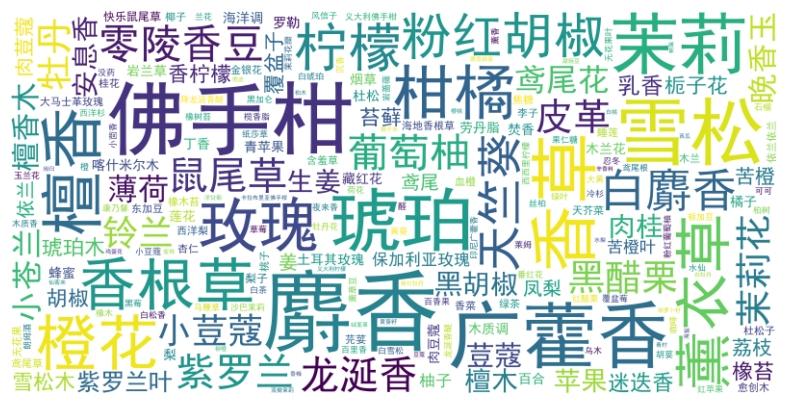

In [26]:
# Word Cloud
wc = WordCloud(font_path='simhei.ttf', width=800, height=400, background_color='white')
wc.generate_from_frequencies(note_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [28]:
# Count fragance
fragrance_counts = {}
for s in df['fragrance']:
    for item in [i.strip() for i in s.split('、') if i.strip()]:
        fragrance_counts[item] = fragrance_counts.get(item, 0) + 1

# Save
with open('data/count_fragrance.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['fragrance', 'count'])
    for item, count in sorted(fragrance_counts.items(), key=lambda x: x[1], reverse=True):
        writer.writerow([item, count])

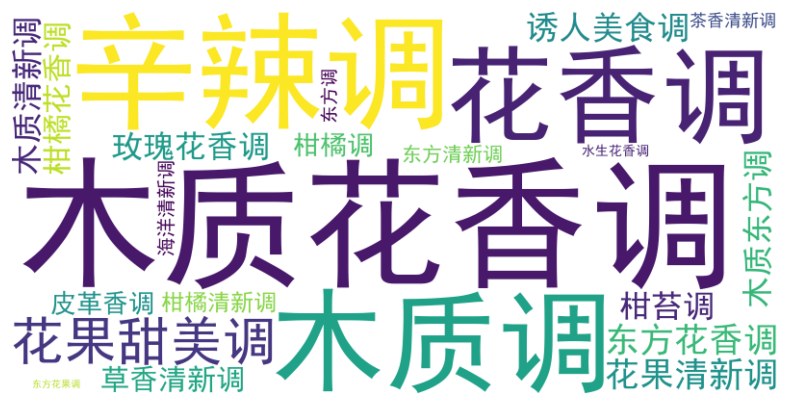

In [30]:
# word cloud
wc = WordCloud(font_path='simhei.ttf', width=800, height=400, background_color='white')
wc.generate_from_frequencies(fragrance_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Embedding

In [ ]:
df = pd.read_csv("data/1976_clean.csv")

In [ ]:
def note_list(row):
    notes = []
    if pd.notna(row["top_notes"]):
        notes += str(row["top_notes"]).split("、")
    if pd.notna(row["middle_notes"]):
        notes += str(row["middle_notes"]).split("、")
    if pd.notna(row["base_notes"]):
        notes += str(row["base_notes"]).split("、")
    return notes

In [ ]:
corpus = df.apply(note_list, axis=1).tolist()

embedding = Word2Vec(
    sentences=corpus,
    vector_size=128,
    window=5, 
    min_count=3,
    sg=1,
    epochs=50
)

In [ ]:
# Save Embedding
embedding.wv.save_word2vec_format("models/note_embedding", binary=False)
print("Embedding training done.")

# Compute Perfume Vectors

In [ ]:
note_vectors = KeyedVectors.load_word2vec_format("models/note_embedding", binary=False)
perfume_vectors = {}

In [ ]:
def get_vectors(note_str):
  if pd.isna(note_str):
    return []
  notes = [n.strip() for n in note_str.split("、")]
  return [note_vectors[n] for n in notes if n in note_vectors]

In [ ]:
def compute_perfume_vector(top_vecs, mid_vecs, base_vecs):
    w_top, w_middle, w_base = 0.2, 0.5, 0.3
    vec = np.zeros(note_vectors.vector_size)
    if top_vecs:
        vec += w_top * np.mean(top_vecs, axis=0)
    if mid_vecs:
        vec += w_middle * np.mean(mid_vecs, axis=0)
    if base_vecs:
        vec += w_base * np.mean(base_vecs, axis=0)
    return vec

In [ ]:
for idx, row in df.iterrows():
    perfume_name = row["name"]
    top_vecs = get_vectors(row["top_notes"])
    mid_vecs = get_vectors(row["middle_notes"])
    base_vecs = get_vectors(row["base_notes"])
    perfume_vec = compute_perfume_vector(top_vecs, mid_vecs, base_vecs)
    perfume_vectors[perfume_name] = perfume_vec

In [ ]:
# Save Perfume Vectors
df_vectors = pd.DataFrame.from_dict(perfume_vectors, orient="index")
df_vectors.to_csv("models/perfume_vectors.csv")
print("Perfume vector computation done.")

# PCA

In [ ]:
# 从洗好的数据集中获取每个香水的第一个scent_note作为分类
df_info = pd.read_csv("data/1976_clean.csv")
df_vec = pd.read_csv("models/perfume_vectors.csv")
if 'Unnamed: 0' in df_vec.columns:
    perfume_names = df_vec.iloc[:,0]
else:
    perfume_names = df_vec.index
X = df_vec.iloc[:,1:].values if 'Unnamed: 0' in df_vec.columns else df_vec.values

# 建立香水名到第一个scent_note的映射
name_to_scent = {}
for _, row in df_info.iterrows():
    name = row['name']
    scent = str(row['scent_notes']).split('、')[0] if pd.notna(row['scent_notes']) else '未知'
    name_to_scent[name] = scent

# 获取每个向量的分类标签
labels = [name_to_scent.get(str(name), '未知') for name in perfume_names]

from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(12,9))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=pd.factorize(labels)[0], cmap='tab10', s=40)
legend_labels = list(pd.unique(labels))
legend_handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(legend_labels))]
ax.legend(legend_handles, legend_labels, title='首个香型', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
ax.set_title('香水向量PCA三维可视化（按首个香型分类）', fontproperties='SimHei')
ax.set_xlabel('主成分1', fontproperties='SimHei')
ax.set_ylabel('主成分2', fontproperties='SimHei')
ax.set_zlabel('主成分3', fontproperties='SimHei')
plt.show()

# Recomendation

In [ ]:
note_vectors = KeyedVectors.load_word2vec_format("models/note_embedding", binary=False)
perfume_vectors_df = pd.read_csv("models/perfume_vectors.csv", index_col=0)
perfume_vectors = perfume_vectors_df.to_dict(orient="index")

In [ ]:
def get_vectors(note_str):
  if pd.isna(note_str):
    return []
  notes = [n.strip() for n in note_str.split("、")]
  return [note_vectors[n] for n in notes if n in note_vectors]

In [ ]:
def compute_perfume_vector(top_vecs, mid_vecs, base_vecs):
    w_top, w_middle, w_base = 0.2, 0.5, 0.3
    vec = np.zeros(note_vectors.vector_size)
    if top_vecs:
        vec += w_top * np.mean(top_vecs, axis=0)
    if mid_vecs:
        vec += w_middle * np.mean(mid_vecs, axis=0)
    if base_vecs:
        vec += w_base * np.mean(base_vecs, axis=0)
    return vec

In [ ]:
like_top_notes = ["葡萄柚","橙子"]
like_middle_notes = ["玫瑰"]
like_base_notes = ["木质"]

like_top_vecs = get_vectors("、".join(like_top_notes))
like_mid_vecs = get_vectors("、".join(like_middle_notes))
like_base_vecs = get_vectors("、".join(like_base_notes))

like_vec = compute_perfume_vector(like_top_vecs, like_mid_vecs, like_base_vecs)

In [ ]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b)) if norm(a) > 0 and norm(b) > 0 else 0

In [ ]:
# Recommend perfumes
sim_scores = {}
for name, vec_dict in perfume_vectors.items():
    vec = np.array(list(vec_dict.values()), dtype=float)
    sim_scores[name] = cosine_similarity(like_vec, vec)
top_n = 10
top_perfumes = sorted(sim_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
print("Recommended perfumes:")
for name, score in top_perfumes:
    print(f"{name}: {score:.4f}")